# Making normalized distributions
- processes an `events[year][ch][sample]` object using `make_events_dict()` per defined region
- plots normalized distributions of a chosen sample for a chosen region

In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
# define your regions here
presel = {
    
    ##### signal-like region
    "LepIsolation": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        },
    },          
    
    ##### QCD-like region
    "LepIsolationInv": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",    
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        },
    },
    
    ##### signal region
    "Signal region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "tagger": " ( ( inclusive_score>0.9) )",        
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score>0.9) )",                    
        },
    },
    
    ##### QCD control region
    "QCD control region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "tagger": " ( ( inclusive_score<0.9) )",        
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score<0.9) )",                    
        },
    }, 
    
    ##### WJets control region
    "WJets control region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "nbjets": "( (n_bjets_L == 0) )",     
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "nbjets": "( (n_bjets_L == 0) )",             
        },
    }, 
    
    ##### TTbar control region
    "TTbar control region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score<0.9) )",        
            "nbjets": "( (n_bjets_T > 0) )",     
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score<0.9) )",            
            "nbjets": "( (n_bjets_T > 0) )",     
        },
    },
}

In [120]:
weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

samples = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

In [ ]:
from make_hists import make_events_dict

years = ["2017", "2016", "2016APV", "2018"]

channels = ["mu"]    # currently supports processing a single channel at a time

events_dict = {}
for ch in channels:
    for region in presel:
        if "LepIsolationInv" in region:
            samples_dir = f"../eos/Jul12QCD_"
        elif "dR" in region:
            samples_dir = f"../eos/Jul15_region_wjets_"            
        else:
            samples_dir = f"../eos/Apr12_presel_"

        events_dict[region] = make_events_dict(years, channels, samples_dir, samples, presel[region], weights, "all", add_tagger_score=True)

# Plotting

In [166]:
color_dict = {
    "LepIsolationInv": "grey",
    "LepIsolation": "purple",
    "Signal region": "red",
    "QCD control region": "orange",
    "WJets control region": "green",
    "TTbar control region": "blue",
}

nice_ch = {
    "mu": "MUON",
    "ele": "ELECTRON"
}

save_as = {
    "LepIsolation": "LepIsolation",
    "LepIsolationInv": "LepIsolationInv",
    "Signal region": "SigRegion",
    "QCD control region": "QCDRegion",
    "WJets control region": "WJetsRegion",
    "TTbar control region": "TTbarRegion",    
}

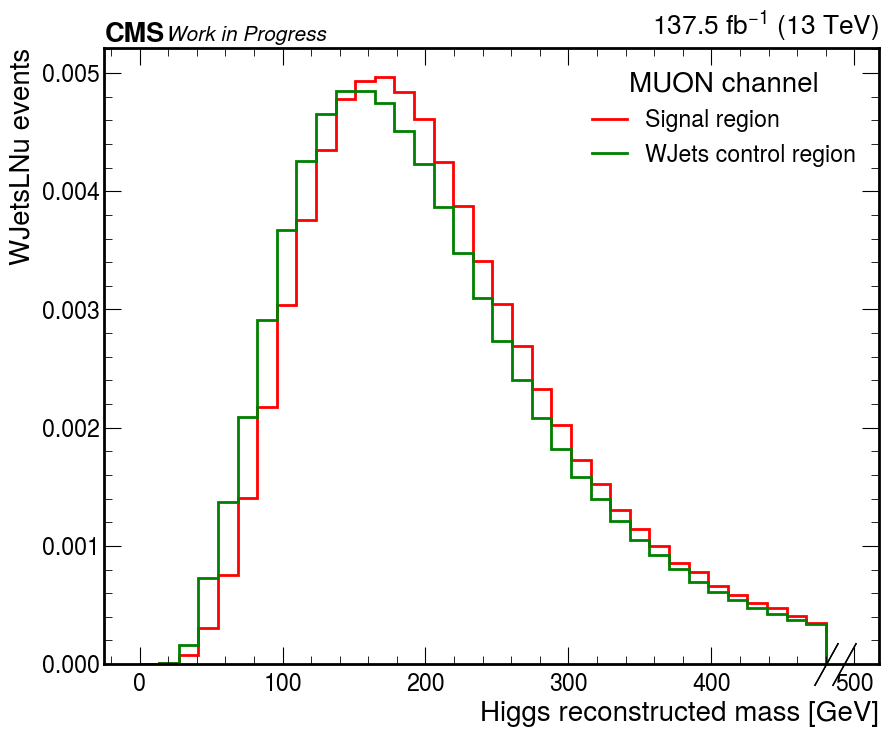

In [167]:
plt.rcParams.update({"font.size": 20})

############################## args up to you
sample = "WJetsLNu"
regions = [
#     "LepIsolation",    
#     "LepIsolationInv",
    "Signal region",
#     "QCD control region",
    "WJets control region",
#     "TTbar control region",
]       

##############################
        
var = "rec_higgs_m"

# make histogram
h = hist2.Hist(
    utils.axis_dict[var],
    hist2.axis.StrCategory([], name="region", growth=True),
)    

for year in years:
    for ch in channels:
    
        for region in regions:
            df = events_dict[region][year][ch][sample]

            h.fill(
                var=df[var],
                region=region,
                weight=df["event_weight"]
            )
            
            
# plot histogram
fig, ax = plt.subplots(figsize=(10, 8))

for region in regions:
    hep.histplot(
        h[{"region": region}],
        ax=ax,
        label=region,
        linewidth=2,
        density=True,
        color=color_dict[region]
    )

ax.set_ylabel(f"{sample} events");  

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    

hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

if len(channels)==1:
    ax.legend(title=f"{nice_ch[ch]} channel")
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/Sep11/rec_higgs_m_{sample}_{ch}")
else:
    ax.legend()
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/Sep11/rec_higgs_m_{sample}")    